In [1]:
from utils import *
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from konlpy.tag import *
from constants import *
from collections import defaultdict
from torchtext.data import Field, BucketIterator, TabularDataset
from konlpy.tag import Mecab
import torchtext
import torch.nn.functional as F
import itertools
from bidirec_LSTM import bidirec_LSTM
import time
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torchtext import data
from torchtext import datasets
from torchtext.data import Field
from torchtext.data import BucketIterator
import torch.optim as optim
from konlpy.tag import Kkma
from config import *
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import os
import sys

## torchtext를 활용해 iterator 만들기

In [2]:
tagger = Komoran()
tokenize = tagger.morphs

torch.manual_seed(0)
REVIEW = Field(sequential=True,
               tokenize=tokenize,
               use_vocab=True,
               include_lengths=True,
               batch_first=True)

LABEL = Field(sequential=False, use_vocab=False)

train, test = data.TabularDataset.splits(
                                         path='./',
                                         train='train.tsv',
                                         test='test.tsv', format='tsv',
                                         fields=[('review', REVIEW), ('label', LABEL)]

                                         )



train, valid = train.split(random_state=random.seed(0))
print("train length : {}".format(len(train)))
print("test length : {}".format(len(test)))
print("valid length : {}".format(len(valid)))


REVIEW.build_vocab(train)

train length : 2054
test length : 734
valid length : 881


In [3]:
device = torch.device("cuda:0")

In [4]:
train_iter, test_iter, val_iter = BucketIterator.splits(
                                                        (train, test, valid), batch_size=MANGO_CONFIG['batch_size'], device=device, 
                                                        sort_key=lambda x: len(x.review), sort_within_batch=True, repeat=False) 

print(len(REVIEW.vocab))

9218


In [5]:
mango_config = Config(MANGO_CONFIG)

model = bidirec_LSTM(mango_config, V=len(REVIEW.vocab))

model.to(device)

bidirec_LSTM(
  (embed): Embedding(9218, 100)
  (lstm): LSTM(100, 256, batch_first=True, bidirectional=True)
  (attn): Linear(in_features=512, out_features=70, bias=False)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (attn2): Linear(in_features=70, out_features=10, bias=False)
  (attn_dist): Softmax()
  (fc): Sequential(
    (0): Linear(in_features=5120, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=3, bias=True)
  )
)

In [6]:
MANGO_CONFIG

{'D': 100,
 'H': 256,
 'H_f': 500,
 'O': 3,
 'STEP': 100,
 'batch_size': 64,
 'bidirec': True,
 'da': 70,
 'num_directions': 2,
 'num_layers': 1,
 'r': 10,
 'use_cuda': True}

In [7]:
# def save_data(i, model, inputs, lengths, targets, preds, dic):
#     dic[i] = {'inputs': inputs, 'lengths': lengths, 'A': model.A, 'targets': targets, 'preds': preds}
#     return dic
dic = defaultdict(dict)

In [8]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
best_valid_loss = float('inf')
epoch_loss = 0
epoch_acc = 0

In [9]:
USE_CUDA = True

In [10]:
STEP = 100
for step in range(STEP):
    model.train()
    losses=[]
    accu = []
    for i, batch in enumerate(train_iter):
        inputs, lengths = batch.review
        if USE_CUDA:
            targets = batch.label.to(device)
        else:
            targets = batch.label

        model.zero_grad()
        preds, loss_P = model(inputs, lengths)


        loss = loss_function(preds, targets) + loss_P

        acc = categorical_accuracy(preds, targets)

        losses.append(float(loss))
        accu.append(acc.item())
        loss.backward()
        optimizer.step()
    string = '[{}/{}] train loss: {:.4f}'.format(step+1, STEP, np.mean(losses))
    print(string)
    string_1 = '[{}/{}] acc: {:.4f}'.format(step+1, STEP, np.mean(accu))
    print(string_1)



    with torch.no_grad():

        model.eval()
        val_losses=[]
        val_accu = []
        for i, batch in enumerate(val_iter):
            inputs, lengths = batch.review
            targets = batch.label
            preds, loss_P = model(inputs, lengths)
            val_loss = loss_function(preds, targets) + loss_P


            acc = categorical_accuracy(preds, targets)

            val_losses.append(float(val_loss))
            val_accu.append(acc.item())

            optimizer.step()
        print()
        string = '[{}/{}] val_loss: {:.4f}'.format(step+1, STEP, np.mean(val_losses))
        print(string)
        string_1 = '[{}/{}] val_acc: {:.4f}'.format(step+1, STEP, np.mean(val_accu))
        print(string_1)
        print()

        if np.mean(val_losses) < best_valid_loss:
            best_valid_loss = np.mean(val_losses)
            print("save model")
            print()

            torch.save(model.state_dict(), 'model.pt')

[1/100] train loss: 3.9648
[1/100] acc: 0.6353

[1/100] val_loss: 5.9980
[1/100] val_acc: 0.4478

save model

[2/100] train loss: 4.3570
[2/100] acc: 0.6293

[2/100] val_loss: 4.1899
[2/100] val_acc: 0.6047

save model

[3/100] train loss: 3.7746
[3/100] acc: 0.7513

[3/100] val_loss: 3.6858
[3/100] val_acc: 0.7894

save model

[4/100] train loss: 3.5268
[4/100] acc: 0.8426

[4/100] val_loss: 4.8006
[4/100] val_acc: 0.5469

[5/100] train loss: 4.1041
[5/100] acc: 0.6589

[5/100] val_loss: 3.6056
[5/100] val_acc: 0.8087

save model

[6/100] train loss: 3.4379
[6/100] acc: 0.8526

[6/100] val_loss: 3.8589
[6/100] val_acc: 0.7160

[7/100] train loss: 3.4755
[7/100] acc: 0.8469

[7/100] val_loss: 3.5118
[7/100] val_acc: 0.8247

save model

[8/100] train loss: 3.2572
[8/100] acc: 0.9069

[8/100] val_loss: 3.7718
[8/100] val_acc: 0.7162

[9/100] train loss: 3.4021
[9/100] acc: 0.8546

[9/100] val_loss: 3.6264
[9/100] val_acc: 0.8064

[10/100] train loss: 3.2242
[10/100] acc: 0.9006

[10/100]


[79/100] val_loss: 2.2965
[79/100] val_acc: 0.8307

[80/100] train loss: 0.2866
[80/100] acc: 1.0000

[80/100] val_loss: 2.3205
[80/100] val_acc: 0.8318

[81/100] train loss: 0.3009
[81/100] acc: 1.0000

[81/100] val_loss: 2.3589
[81/100] val_acc: 0.8263

[82/100] train loss: 0.2893
[82/100] acc: 0.9991

[82/100] val_loss: 2.2480
[82/100] val_acc: 0.8263

[83/100] train loss: 0.3309
[83/100] acc: 0.9991

[83/100] val_loss: 2.2410
[83/100] val_acc: 0.8203

[84/100] train loss: 0.2765
[84/100] acc: 0.9995

[84/100] val_loss: 2.3105
[84/100] val_acc: 0.8240

[85/100] train loss: 0.2042
[85/100] acc: 0.9995

[85/100] val_loss: 2.7242
[85/100] val_acc: 0.7970

[86/100] train loss: 0.1836
[86/100] acc: 0.9920

[86/100] val_loss: 2.4186
[86/100] val_acc: 0.8270

[87/100] train loss: 0.1284
[87/100] acc: 1.0000

[87/100] val_loss: 2.4688
[87/100] val_acc: 0.8248

[88/100] train loss: 0.1590
[88/100] acc: 1.0000

[88/100] val_loss: 2.3896
[88/100] val_acc: 0.8178

[89/100] train loss: 0.1666
[

In [11]:
def save_data(i, model, inputs, lengths, targets, preds, dic):
    dic[i] = {'inputs': inputs, 'lengths': lengths, 'A': model.A, 'targets': targets, 'preds': preds}
    return dic

In [12]:
model.load_state_dict(torch.load(
    'model.pt', map_location=lambda storage, loc: storage))
print(model)


y_hat = []
y_real = []

num_equal=0
dic = defaultdict(dict)
with torch.no_grad():
    model.eval()
    num_equal = 0
    val_loss = 0
    for i, batch in enumerate(test_iter):

        inputs, lengths = batch.review
        targets = batch.label
        
        if 0 in lengths:
            idxes = torch.arange(inputs.size(0))
            if USE_CUDA:
                idxes = idxes.cuda()
            mask = idxes[lengths.ne(0)].long()

            inputs = inputs.index_select(0, mask)
            lengths = lengths.masked_select(lengths.ne(0))
            targets = targets.index_select(0, mask)


        preds, loss_P = model(inputs, lengths)
        loss = loss_function(preds, targets) + loss_P


        acc = categorical_accuracy(preds, targets)

        max_preds = preds.argmax(dim = 1, keepdim = True).squeeze(0) # get the index of the max probability
        correct = max_preds.squeeze(1).eq(targets) # 같은것만 찾는 코드

        max_preds = max_preds.squeeze()
        y_hat.append(max_preds.tolist())
        y_real.append(targets.tolist())
        num_equal += int(torch.eq(max_preds, targets).sum())
        val_loss += loss.item()
        dic = save_data(i, model, inputs, lengths, targets, preds, dic)
print("Accuracy : " , num_equal / len(pd.DataFrame.from_csv('test.tsv', sep='\t', header=None)))
print("loss : ", val_loss/len(test_iter))


y_hat_flat = list(itertools.chain(*y_hat))
y_real_flat = list(itertools.chain(*y_real))

bidirec_LSTM(
  (embed): Embedding(9218, 100)
  (lstm): LSTM(100, 256, batch_first=True, bidirectional=True)
  (attn): Linear(in_features=512, out_features=70, bias=False)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (attn2): Linear(in_features=70, out_features=10, bias=False)
  (attn_dist): Softmax()
  (fc): Sequential(
    (0): Linear(in_features=5120, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=3, bias=True)
  )
)
Accuracy :  0.837874659400545
loss :  1.713641067345937


/home/gpu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:46: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


## confusion_matrix

In [13]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_real_flat,y_hat_flat))

[[100  13  18]
 [ 12 152  20]
 [ 40  16 363]]


In [14]:
print(classification_report(y_real_flat, y_hat_flat, target_names=['class 0', 'class 1','class missing' ]))

               precision    recall  f1-score   support

      class 0       0.66      0.76      0.71       131
      class 1       0.84      0.83      0.83       184
class missing       0.91      0.87      0.89       419

    micro avg       0.84      0.84      0.84       734
    macro avg       0.80      0.82      0.81       734
 weighted avg       0.84      0.84      0.84       734



## 결과를 json으로 저장

In [15]:
result_dic = classification_report(y_real_flat, y_hat_flat, target_names=['class 0', 'class 1','class missing' ], output_dict=True)
result_dic['param'] = MANGO_CONFIG
err = ( result_dic['class 0']['f1-score'] + result_dic['class 1']['f1-score'] ) / 2

In [16]:
import json
with open('logging/{}.json'.format(err), 'w', encoding='utf-8') as make_file:
    json.dump(result_dic, make_file, ensure_ascii=False, indent="\t")

## 시각화

In [17]:
def get_reviews(inputs, lengths):
    max_len = max(lengths)
    reviews = []
    for s, l in zip(inputs, lengths):
        if l == max_len:
            reviews.append([REVIEW.vocab.itos[w.item()] for w in s])
        else:
            num_add_pad = max_len - l

            #reviews.append([REVIEW.vocab.itos[w.item()] for w in s] + ['<pad>']*(num_add_pad-1))
            reviews.append([REVIEW.vocab.itos[w.item()] for w in s])
    return reviews

def build_matrix(dic, sample_idx):
    A = dic[sample_idx]['A'].sum(1)
    if USE_CUDA:
        A_norm = (A / A.max(1)[0].unsqueeze(1)).data.cpu().numpy()
    else:
        A_norm = (A / A.max(1)[0].unsqueeze(1)).data.numpy()
    inputs = dic[sample_idx]['inputs']
    lengths = dic[sample_idx]['lengths']
    targets = dic[sample_idx]['targets']
    preds = dic[sample_idx]['preds']

    reviews = get_reviews(inputs, lengths)
    return reviews, A_norm, targets, preds

def span_str(color, input_str):
    string = '<span style="margin-left:3px;background-color:rgba({})">{}</span>'.format(color, input_str)
    return string


def write_html_vis(reviews, A_norm, targets, preds, vis_path):
    max_preds = preds.argmax(dim = 1, keepdim = True).squeeze(0)
    max_preds = max_preds.squeeze()
    preds = max_preds



    with open(vis_path, 'w', encoding='utf-8') as file:
        print('<html style="margin:0;padding:0;"><body style="margin:0;padding:0;">\n', file=file)
        print('<div style="margin:25px;">\n', file=file)
        #print('<h1>Model: {} | Total Accuracy: {:.4f}</h1>'.format(model_path.split('/')[-1].split('.')[0], num_equal / len(df_test)), file=file)


        print('<h2> This Sample Accurary: {:.4f}</h2>'.format((torch.eq(targets, preds).float().sum()/targets.size(0)).item()), file=file)
        for review, score, target, preds in zip(reviews, A_norm, \
                                                targets.data.cpu().numpy(), preds.data.cpu().numpy()):
            alphas = ['{:.2f}'.format(s) for s in score]
            print('<p style="margin:10px;">\n', file=file)
            if target == preds:
                color = '154,226,143, 0.7'
                input_str = '[target: {}| pred: {}]'
                string = span_str(color, input_str)
                print(string.format(target, preds), file=file)
            else:
                color = '203,127,230, 0.7'
                input_str = '[target: {}| pred: {}]'
                string = span_str(color, input_str)
                print(string.format(target, preds), file=file)

            for word, alpha in zip(review, alphas):
                color = '255,50,50, {}'
                input_str = '{}'
                string = span_str(color, input_str)
                print(('\t' + string + '\n').format(alpha, word), file=file)
            print('</p>\n', file=file)
        print('</div>\n', file=file)
        print('</body></html>', file=file)

In [18]:
sample_idx = np.random.randint(len(dic))
vis_path = 'figure/figure_{}[{}].html'.format(err, sample_idx)
reviews, A_norm, targets, preds = build_matrix(dic, sample_idx)
write_html_vis(reviews, A_norm, targets, preds, vis_path)

## TODO : 임베딩 벡터 시각화 및 해석

In [19]:
def new_data(i, model, inputs, lengths, targets, preds, dic):
    dic[i] = {'inputs': inputs, 'lengths': lengths, 'A': model.A, 'targets': targets, 'preds': preds, 'M':model.M}
    return dic

In [20]:
model.load_state_dict(torch.load(
    'model.pt', map_location=lambda storage, loc: storage))
print(model)


y_hat = []
y_real = []

num_equal=0
newdic = defaultdict(dict)
with torch.no_grad():
    model.eval()
    num_equal = 0
    val_loss = 0
    for i, batch in enumerate(test_iter):

        inputs, lengths = batch.review
        targets = batch.label
        
        if 0 in lengths:
            idxes = torch.arange(inputs.size(0))
            if USE_CUDA:
                idxes = idxes.cuda()
            mask = idxes[lengths.ne(0)].long()

            inputs = inputs.index_select(0, mask)
            lengths = lengths.masked_select(lengths.ne(0))
            targets = targets.index_select(0, mask)


        preds, loss_P = model(inputs, lengths)
        loss = loss_function(preds, targets) + loss_P


        acc = categorical_accuracy(preds, targets)

        max_preds = preds.argmax(dim = 1, keepdim = True).squeeze(0) # get the index of the max probability
        correct = max_preds.squeeze(1).eq(targets) # 같은것만 찾는 코드

        max_preds = max_preds.squeeze()
        y_hat.append(max_preds.tolist())
        y_real.append(targets.tolist())
        num_equal += int(torch.eq(max_preds, targets).sum())
        val_loss += loss.item()
        newdic = new_data(i, model, inputs, lengths, targets, preds, newdic)
print("Accuracy : " , num_equal / len(pd.DataFrame.from_csv('test.tsv', sep='\t', header=None)))
print("loss : ", val_loss/len(test_iter))


y_hat_flat = list(itertools.chain(*y_hat))
y_real_flat = list(itertools.chain(*y_real))

bidirec_LSTM(
  (embed): Embedding(9218, 100)
  (lstm): LSTM(100, 256, batch_first=True, bidirectional=True)
  (attn): Linear(in_features=512, out_features=70, bias=False)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (attn2): Linear(in_features=70, out_features=10, bias=False)
  (attn_dist): Softmax()
  (fc): Sequential(
    (0): Linear(in_features=5120, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=3, bias=True)
  )
)
Accuracy :  0.837874659400545
loss :  1.713641067345937


/home/gpu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:46: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


In [21]:
re = newdic[0]['M']

In [22]:
for i in range(1, len(newdic) -1):
    a = newdic[i]['M']
    re = torch.cat((re,a), 0)   

In [23]:
embedding_result_flattened = re.view(704, -1)

In [24]:
import numpy as np
from sklearn.manifold import TSNE
embedding_x = embedding_result_flattened.cpu().numpy()

## 2차원

In [25]:
embedding_tsne = TSNE(n_components=2).fit_transform(embedding_x)

In [26]:
embedding_df = pd.DataFrame(embedding_tsne, columns=['dim0', 'dim1'])

In [27]:
target = list(newdic[0]['targets'].cpu().numpy())

In [28]:
for i in range(1, len(newdic) -1):
    a = list(newdic[i]['targets'].cpu().numpy())
    target = target + a   

In [29]:
tar = pd.DataFrame(target, columns=['tar'])

In [30]:
popular_df2 = pd.concat([tar, embedding_df], axis=1)

In [31]:
popular_df2.tail()

,tar,dim0,dim1
699,0,4.228856,-3.892847
700,1,2.117187,1.129561
701,1,-10.159722,-28.154322
702,0,-2.946775,-16.080044
703,2,-2.823514,11.435606


In [32]:
from matplotlib import cm

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


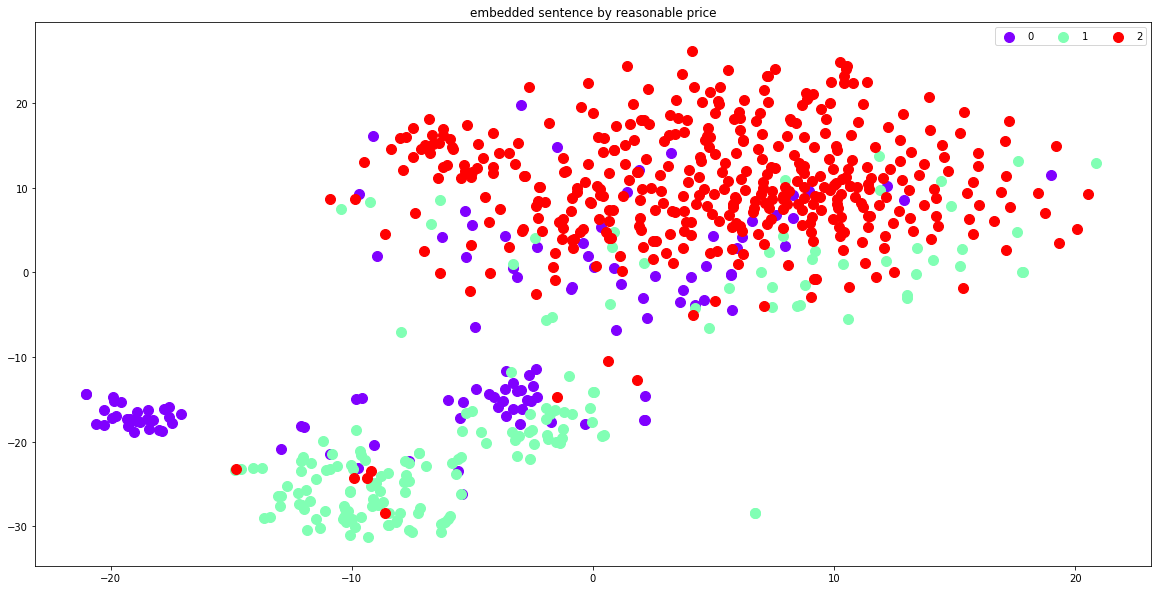

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

origin_dict = {origin:ix for ix, origin in enumerate(popular_df2.tar.unique().tolist())}
colors = cm.rainbow(np.linspace(0, 1, len(popular_df2.tar.unique())))

g = popular_df2.groupby('tar')

fig, ax = plt.subplots(figsize=(20, 10))
for ix, (label, data) in enumerate(g):
    
    color_list = [origin_dict[x] for x in data.tar]
    
    x = data.dim0
    y = data.dim1
    ax.scatter(x, y, c=colors[ix], label=label, cmap='jet', s=100)
    

ax.legend(loc='upper right', ncol=3)

plt.title("embedded sentence by reasonable price")
plt.show()
